# GRU model

We start by importing the necessary libraries...

In [1]:
import torch
import torch.nn as nn
import sys
import copy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from core.util.get_datasets import get_park_dataset
from tqdm.notebook import tqdm
from core.util.loss_functions import zap_loss

## Setup
This section contains the setup for converting our data to something PyTorch can understand.
### Set hyperparameters for the model

In [2]:
batch_size = 512
learning_rate = 0.001
EPOCHS = 10
lookback = 24
loss_function = zap_loss

### Get the park datasets and convert them to torch tensors

In [3]:
x_train, y_train, x_val, y_val, x_test, y_test = get_park_dataset(lookback, 24)
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
x_val = torch.tensor(x_val).float()
y_val = torch.tensor(y_val).float()
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

### If the host has CUDA, it will use the GPU for computation

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Convert to specific Datasets for conversion to Dataloaders
This any class inheriting Dataset must implement `__init__`, `__len__`, and `__getitem__`.
It is also in this class we move the features and target to the GPU if applicable.

In [5]:
class TreforData(Dataset):
    """Initialize Trefor dataset."""

    def __init__(self, x: torch.tensor, y: torch.tensor) -> None:
        """Initialize dataset.

        Arguments:
            x: feature as torch
            y: target as torch

        """
        self.x = x.to(device)
        self.y = y.to(device)

    def __len__(self) -> int:
        """Return length of dataset."""
        return len(self.x)

    def __getitem__(self, i: int) -> tuple:
        """Return tuple from dataset."""
        return self.x[i], self.y[i]


train_dataset = TreforData(x_train, y_train)
val_dataset = TreforData(x_val, y_val)
test_dataset = TreforData(x_test, y_test)

### Convert to data to dataloaders
The DataLoader class helps us split the dataset into batches, and can also shuffle the data in between epochs if desired.

In [6]:
training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Creation of our simple GRU model
This implementation consits of three layers, defined in the `forward` method.
1. GRU
2. LeakyReLU
3. Linear

In [7]:
class SimpleGRU(nn.Module):
    """Simple GRU implementation."""

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
    ) -> None:
        """Initialize the GRU and its layers."""
        super(SimpleGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size

        self.gru = nn.GRU(
            input_size, hidden_size, num_layers=num_layers, batch_first=True
        )
        self.nl = nn.LeakyReLU()
        self.fc = nn.Linear((hidden_size * lookback), 24)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """Forward pass for the model."""
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.nl(out)
        out = self.fc(out)
        return out


model = SimpleGRU(1, 10, 1)
model.to(device)

## Running the Model

This is computationally heavy part

### Training for only 1 epoch
Here we use Adam as optimizer, and set the learning rate.

When training an epoch, we iterate all the batches, make predictions using the model, and backpropagate using the loss.

We have to reset the gradients at every batch, as otherwise the gradient would be a mix of the newly computed and the old one, which is not desirable.

Lastly, we return the average loss for the epoch.

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


def train_one_epoch() -> float:
    """Train one epoch."""
    running_loss = 0.0

    for i, (inputs, target) in enumerate(training_loader):
        # Reset the gradients
        optimizer.zero_grad()

        # Make predictions for this batch
        predictions = model(inputs)

        # Compute the loss and its gradient
        target = target.squeeze(-1)
        loss = loss_function(predictions, target)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
    return running_loss / len(training_loader)

### Training loop
Iterate the epochs, training and validating the model.

We save the model, in case it is better than any of the previous we have seen.

In [9]:
epoch_number = 0
best_v_loss = sys.maxsize
best_model = None

plot_train_loss = []
plot_val_loss = []

for epoch in tqdm(range(EPOCHS), desc="Iterating epochs"):
    # Make sure gradient tracking is on, and do a pass over the data
    model.train()
    avg_loss = train_one_epoch()

    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization
    model.eval()

    # Run the validation set, to see how the model performed this epoch
    # Disable gradient computation and reduce memory consumption
    with torch.no_grad():
        running_v_loss = 0.0
        for i, (v_inputs, v_target) in enumerate(validation_loader):
            v_predictions = model(v_inputs)
            v_target = v_target.squeeze(-1)
            running_v_loss += loss_function(v_predictions, v_target).item()

    # Log the running loss averaged per batch
    # for both training and validation
    avg_v_loss = running_v_loss / len(validation_loader)
    plot_train_loss.append(avg_loss)
    plot_val_loss.append(avg_v_loss)

    # If this model has the lowest loss, we save its state for later reference
    if avg_v_loss < best_v_loss:
        best_v_loss = avg_v_loss
        best_model = copy.deepcopy(model)

Iterating epochs:   0%|          | 0/10 [00:00<?, ?it/s]

### Use the best model to make predictions on the test set
This is very similar to the validation predictions above, only that this is run just once.

In [10]:
best_model.eval()
predicted = []
t_loss = 0

with torch.no_grad():
    for i, t_data in enumerate(testing_loader):
        t_inputs, t_target = t_data
        t_predictions = best_model(t_inputs)
        predicted.append(t_predictions)
        t_loss += loss_function(t_predictions, t_target).item()

predicted = torch.cat(predicted, dim=0)
t_loss /= len(testing_loader)
print(f"Avg loss: {t_loss:>8f} \n")

Avg loss: 0.008746 



## Plotting
Show some nice output :)
### Training- and validation loss

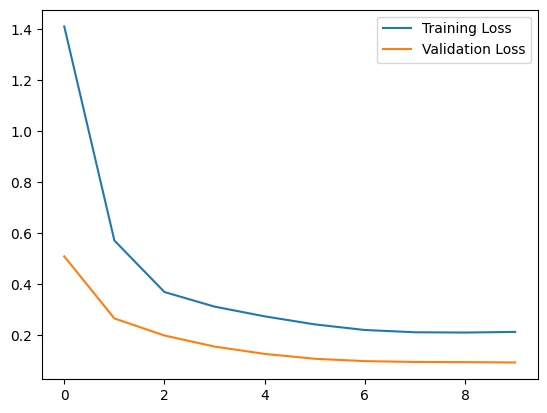

In [11]:
plt.clf()
plt.plot(plot_train_loss, label="Training Loss")
plt.plot(plot_val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Predictions- and actual consumption

In [12]:
def plot_predictions(startday: int, endday: int) -> None:
    """Plot the model predictions and the actual values from startDay to endDay."""
    first_column_actual = y_test[startday * 24].flatten().to("cpu")
    first_column_predicted = predicted[startday * 24].flatten().to("cpu")
    increment = 1 if startday < endday else -1
    for i in range(startday + increment, endday, increment):
        first_column_actual = torch.cat(
            (first_column_actual, y_test[i * 24].flatten().to("cpu"))
        )
        first_column_predicted = torch.cat(
            (first_column_predicted, predicted[i * 24].flatten().to("cpu"))
        )
    plt.plot(first_column_actual, label="First Column Actual Consumption")
    plt.plot(first_column_predicted, label="First Column Predicted Consumption")
    plt.xlabel("Hour")
    plt.ylabel("Consumption")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Position the legend outside
    plt.show()

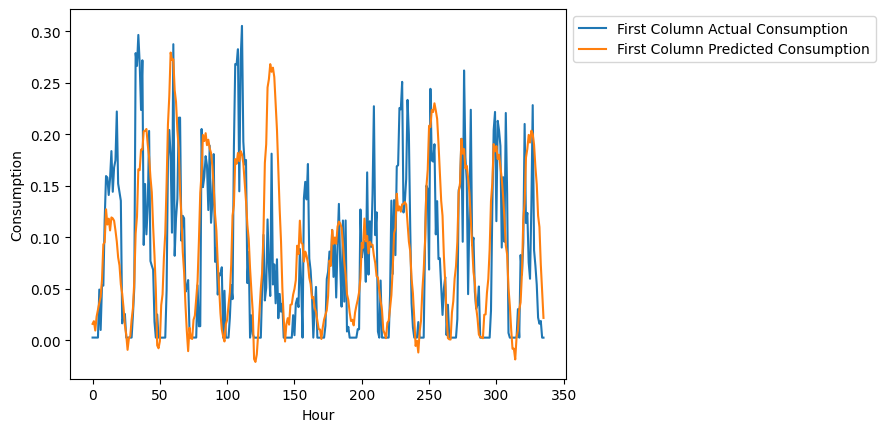

In [13]:
plot_predictions(500, 514)